## Generative model for a Human Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
from sonar import sonar, utils, generator

In [4]:
rel_kernel_path = 'test/ISS-pancreas' #"."


In [5]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [6]:
n_sample = 1

# Load the pancreas tissue matrix:

tissue_matrix = np.load(os.path.join( *rel_kernel_path.split('/'), 'data','sample_matrices.npz'))['sample_'+str(n_sample)]

In [7]:
# plt.figure(figsize=(10,10))
# plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

# # Create a legend for different tissue types:
# legend_elements = [plt.scatter([],[],c=plt.cm.nipy_spectral(i/len(cluster_labels)),label=cluster_labels[i]) for i in range(len(cluster_labels))]

# plt.legend(handles=legend_elements,loc='upper right')

In [8]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.4).numpy()

del tissue_matrix

In [9]:
# plt.imshow(rescaled.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(rescaled.sum(0)!=0).astype(float))

Changing tasks between cpu and gpu

In [10]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

# unrelated to the NoteBook, the example of a tensor and how to work with it
new_tens = t.zeros(2,2,2, device=device).cuda()
new_tens.device

device(type='cuda', index=0)

In [11]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ =150
lin = 10

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_,radii = son.co_occurrence_from_tensor(rescaled,interpolate=False,normalize=False)


/dh-projects/ag-ishaque/analysis/tiesmeys/src/sonar/sonar/sonar.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/torch/csrc/utils/tensor_new.cpp:245.)
  kernels = t.tensor(kernels,dtype=torch.float32)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/sonar/sonar/sonar.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernels = t.tensor(self.kernels,dtype=torch.float32,device=device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 998.00 MiB (GPU 0; 31.75 GiB total capacity; 6.91 GiB already allocated; 640.75 MiB free; 8.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Run generative model:

In [ ]:
gen = generator.Generator(sonar=son)

sample = gen.generate(template_co_occurrence=cooc_template_,
                      iterations=800,
                      momentum=0.5,
                      lr=5,
                      render_args = {'steps_per_frame':5,'save_dir':'./test/ISS-pancreas/output/generator-frames'})
# plt.imshow(rescaled[8])
# plt.rcParams['figure.figsize'] = [11, 6]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:25<00:00,  9.33it/s]


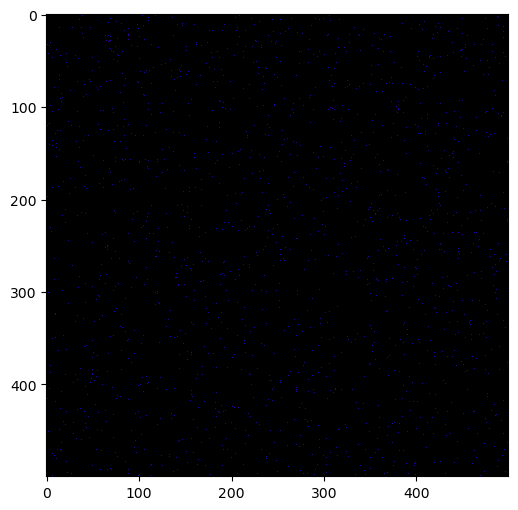

In [ ]:
plt.figure(figsize=(6,6))

plt.imshow(sample.argmax(0).cpu(),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1)